# Celda 1: Instalación de librerías necesarias

In [1]:
!pip install numpy matplotlib qiskit qiskit-aer pylatexenc

# Celda 2: Importación de librerías

In [2]:
import numpy as np
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

# Celda 3: Funciones auxiliares

In [3]:

def convert_to_mixed_radix(x, moduli):
    """
    Convierte un número entero en su representación de base mixta según los módulos dados.

    Args:
        x (int): Número entero que se desea convertir.
        moduli (list): Lista de módulos que definen las bases mixtas.

    Returns:
        tuple: Representación del número en base mixta (una tupla de dígitos).
    """
    digits = []  # Lista para almacenar los dígitos de la representación mixta.
    remainder = x  # Inicializar el número restante a convertir.

    # Iterar sobre los módulos en orden inverso para calcular los dígitos.
    for m in reversed(moduli):
        digits.insert(0, remainder % m)  # Calcular el dígito correspondiente al módulo actual.
        remainder = remainder // m  # Actualizar el resto dividiendo por el módulo actual.

    return tuple(digits)  # Devolver la representación como una tupla.

def mixed_radix_to_int(t, moduli):
    """
    Reconstruye un número entero a partir de su representación en base mixta.

    Args:
        t (tuple): Representación en base mixta (tupla de dígitos).
        moduli (list): Lista de módulos que definen las bases mixtas.

    Returns:
        int: Número entero reconstruido.
    """
    # Inicializar el valor reconstruido
    value = 0

    # Iterar sobre los dígitos y módulos en orden directo
    for digit, m in zip(t, moduli):
        value = value * m + digit  # Acumular el valor usando la base mixta

    return value

# Ajuste para manejar listas de tuplas
def process_hidden_subgroup(hidden_subgroup, moduli):
    """
    Convierte una lista de representaciones en base mixta a números enteros.

    Args:
        hidden_subgroup (list): Lista de tuplas que representan el subgrupo oculto.
        moduli (list): Lista de módulos que definen las bases mixtas.

    Returns:
        list: Lista de números enteros reconstruidos.
    """
    return [mixed_radix_to_int(item, moduli) for item in hidden_subgroup]

# Celda 4: Implementación de la QFT personalizada

In [4]:
def qft_group(moduli):
    """
    Construye un circuito que aplica la QFT optimizada a un grupo definido por sus módulos.

    Args:
        moduli (list): Lista de módulos del grupo.

    Returns:
        QuantumCircuit: Circuito cuántico que implementa la QFT optimizada.
    """
    bits_per_factor = [math.ceil(math.log2(m)) for m in moduli]
    total_qubits = sum(bits_per_factor)
    qc = QuantumCircuit(total_qubits)

    # Aplicar Hadamard a todos los qubits en paralelo
    for i in range(total_qubits):
        qc.h(i)

    # Aplicar rotaciones de fase por grupos de módulos
    qubit_offset = 0
    for idx, m in enumerate(moduli):
        n_qubits = bits_per_factor[idx]

        # Aplicar rotaciones dentro de este grupo de qubits
        for layer in range(1, n_qubits):
            for i in range(n_qubits - layer):
                j = i + layer
                angle = 2 * np.pi / m * (2 ** layer)
                qc.cp(angle, qubit_offset + j, qubit_offset + i)

        qubit_offset += n_qubits

    return qc


# Celda 5: Implementación del oráculo Uf

In [5]:
def Uf(qc, control_reg, target_reg, f_mapping, moduli):
    """
    Implementa el oráculo cuántico Uf para el problema del subgrupo oculto.

    Args:
        qc (QuantumCircuit): Circuito cuántico al que se añade el oráculo.
        control_reg (QuantumRegister): Registro de control.
        target_reg (QuantumRegister): Registro objetivo.
        f_mapping (dict): Mapeo entre índices y valores objetivo.
        moduli (list): Lista de módulos del grupo.

    Returns:
        QuantumCircuit: Circuito con el oráculo añadido.
    """
    bits_per_factor = [math.ceil(math.log2(m)) for m in moduli]

    for idx, f_val in f_mapping.items():
        rep = convert_to_mixed_radix(idx, moduli)
        control_str = ''.join([format(d, f'0{bp}b') for d, bp in zip(rep, bits_per_factor)])
        target_str = format(f_val, f'0{len(target_reg)}b')

        # Configurar controles en estado 0 aplicando puertas X cuando sea necesario
        for j, bit in enumerate(control_str):
            if bit == '0':
                qc.x(control_reg[j])

        # Aplicar XOR entre el valor actual del registro objetivo y f(g)
        # Esto se implementa con puertas X controladas (CNOT)
        for k, bit in enumerate(target_str):
            if bit == '1':
                qc.mcx(control_reg[:], target_reg[k])

        # Restaurar los controles a su estado original
        for j, bit in enumerate(control_str):
            if bit == '0':
                qc.x(control_reg[j])

    return qc


# Celda 6: Construcción del circuito HSP

In [6]:
def hsp_solver(f_mapping, moduli, n_target):
    """
    Construye el circuito cuántico completo para resolver el problema del subgrupo oculto (HSP)
    utilizando una QFT personalizada.

    Args:
        f_mapping (dict): Mapeo entre índices y valores objetivo.
        moduli (list): Lista de módulos del grupo.
        n_target (int): Número de qubits en el registro objetivo.

    Returns:
        QuantumCircuit: Circuito cuántico completo.
    """
    bits_per_factor = [math.ceil(math.log2(m)) for m in moduli]
    n_control = sum(bits_per_factor)

    # Crear registros cuánticos y clásicos
    control_reg = QuantumRegister(n_control, 'control')
    target_reg = QuantumRegister(n_target, 'target')
    c_control = ClassicalRegister(n_control, 'c_control')
    c_target = ClassicalRegister(n_target, 'c_target')

    qc = QuantumCircuit(control_reg, target_reg, c_control, c_target)

    # Paso 1: Aplicar la QFT personalizada en lugar de la superposición inicial
    qft_circuit = qft_group(moduli)
    qc.append(qft_circuit.to_gate(), control_reg)

    # Paso 2: Aplicar el oráculo Uf
    Uf(qc, control_reg, target_reg, f_mapping, moduli)

    # Paso 3: Medir registro objetivo
    qc.measure(target_reg, c_target)

    # Paso 4: Aplicar la QFT inversa al registro de control
    qc.append(qft_circuit.inverse().to_gate(), control_reg)

    # Paso 5: Medir registro de control
    qc.measure(control_reg, c_control)

    return qc


# Celda 7: Extracción del subgrupo Oculto

In [7]:
def extract_hidden_subgroup_improved(counts, moduli, tolerance=0.15, frequency_threshold=0.03):
    """
    Extrae el subgrupo oculto a partir de los resultados de medición en un circuito cuántico,
    sin generar todos los elementos del grupo y considerando la frecuencia de las mediciones.

    Args:
        counts (dict): Diccionario con los resultados de medición (bitstrings y sus frecuencias).
        moduli (list): Lista de módulos que definen la estructura del grupo.
        tolerance (float): Tolerancia para determinar la validez de las fases.
        frequency_threshold (float): Umbral de frecuencia relativa para considerar una medición.

    Returns:
        list: Lista ordenada de elementos que forman el subgrupo oculto.
    """
    # Calcular el número total de mediciones
    total_counts = sum(counts.values())

    # Filtrar mediciones por frecuencia y convertir a representación mixta
    S = []  # Lista de tuplas (representación mixta, frecuencia relativa)
    bits_per_factor = [math.ceil(math.log2(m)) for m in moduli]

    for key, count in counts.items():
        # Calcular la frecuencia relativa
        frequency = count / total_counts

        # Filtrar por umbral de frecuencia
        if frequency >= frequency_threshold:
            parts = key.split()
            if len(parts) > 0:
                control_str = parts[0]
                control_int = int(control_str, 2)

                # Conversión a representación mixta
                mixed_rep = []
                remaining = control_int
                for m, bits in zip(reversed(moduli), reversed(bits_per_factor)):
                    mask = (1 << bits) - 1
                    mixed_rep.insert(0, remaining & mask)
                    remaining >>= bits

                # Almacenar la representación mixta junto con su frecuencia
                S.append((tuple(mixed_rep), frequency))

    # Ordenar las mediciones por frecuencia (de mayor a menor)
    S.sort(key=lambda x: x[1], reverse=True)

    # Extraer solo las representaciones mixtas
    S_reps = [rep for rep, _ in S]

    # Encontrar generadores del subgrupo oculto
    H_generators = []

    # Función para verificar si un elemento satisface las condiciones de fase
    def is_valid_element(element):
        for rep in S_reps:
            phase = sum(element[k] * rep[k] / moduli[k] for k in range(len(moduli)))
            if abs(phase - round(phase)) > tolerance:
                return False
        return True

    # Buscar generadores simples (con un solo componente no nulo)
    for i in range(len(moduli)):
        for value in range(1, moduli[i]):
            # Crear un candidato a generador
            candidate = [0] * len(moduli)
            candidate[i] = value
            candidate = tuple(candidate)

            if is_valid_element(candidate):
                H_generators.append(candidate)

    # Si no se encontraron generadores, probar con combinaciones más complejas
    if not H_generators:
        # Probar con combinaciones de dos componentes no nulos
        for i in range(len(moduli)):
            for j in range(i+1, len(moduli)):
                for vi in range(1, moduli[i]):
                    for vj in range(1, moduli[j]):
                        candidate = [0] * len(moduli)
                        candidate[i] = vi
                        candidate[j] = vj
                        candidate = tuple(candidate)

                        if is_valid_element(candidate):
                            H_generators.append(candidate)



    # Si aún no hay generadores, el subgrupo es trivial (solo el elemento identidad)
    if not H_generators:
        return [(0,) * len(moduli)]

    # Generar el subgrupo completo a partir de los generadores
    H = {(0,) * len(moduli)}  # Empezar con el elemento identidad

    # Función para sumar elementos en el grupo (módulo los módulos correspondientes)
    def group_add(a, b):
        return tuple((a[i] + b[i]) % moduli[i] for i in range(len(moduli)))

    # Generar el subgrupo completo usando los generadores
    old_size = 0
    while old_size < len(H):
        old_size = len(H)
        new_elements = set()

        for g in H:
            for h in H_generators:
                new_elements.add(group_add(g, h))

        H.update(new_elements)

    return sorted(list(H))


# Celda 8: Ejecución del circuito y extracción del subgrupo oculto

In [8]:
# Número total de elementos
total_elements = (2**14)*3

# Secuencia base
base_sequence = [0, 1, 2]

# Definición de datos periódicos y parámetros iniciales

data2= (base_sequence * (total_elements // len(base_sequence))) + base_sequence[:total_elements % len(base_sequence)]# Subgrupo costante en clases laterales
moduli = (2,2,2,2,2,2,2,2,2,2,2,2,2,2,3)
n_target = math.ceil(math.log2(max(data2) + 1))
f_mapping = dict(enumerate(data2))
print(f_mapping)
# Construcción del circuito HSP
qc = hsp_solver(f_mapping, moduli, n_target)

# Simulación del circuito usando AerSimulator de Qiskit
simulator = AerSimulator()
transpiled_qc = transpile(qc, simulator)
result = simulator.run(transpiled_qc,shots=10000).result()
counts = result.get_counts()
print(counts)
# Extracción del subgrupo oculto a partir de los resultados medidos
hidden_subgroup = extract_hidden_subgroup_improved(counts, moduli)

# Conversión del subgrupo oculto a enteros
hidden_subgroup_int = process_hidden_subgroup(hidden_subgroup, moduli)

print("Subgrupo detectado (enteros):", hidden_subgroup_int)
print("Subgrupo detectado:", hidden_subgroup)



{0: 0, 1: 1, 2: 2, 3: 0, 4: 1, 5: 2, 6: 0, 7: 1, 8: 2, 9: 0, 10: 1, 11: 2, 12: 0, 13: 1, 14: 2, 15: 0, 16: 1, 17: 2, 18: 0, 19: 1, 20: 2, 21: 0, 22: 1, 23: 2, 24: 0, 25: 1, 26: 2, 27: 0, 28: 1, 29: 2, 30: 0, 31: 1, 32: 2, 33: 0, 34: 1, 35: 2, 36: 0, 37: 1, 38: 2, 39: 0, 40: 1, 41: 2, 42: 0, 43: 1, 44: 2, 45: 0, 46: 1, 47: 2, 48: 0, 49: 1, 50: 2, 51: 0, 52: 1, 53: 2, 54: 0, 55: 1, 56: 2, 57: 0, 58: 1, 59: 2, 60: 0, 61: 1, 62: 2, 63: 0, 64: 1, 65: 2, 66: 0, 67: 1, 68: 2, 69: 0, 70: 1, 71: 2, 72: 0, 73: 1, 74: 2, 75: 0, 76: 1, 77: 2, 78: 0, 79: 1, 80: 2, 81: 0, 82: 1, 83: 2, 84: 0, 85: 1, 86: 2, 87: 0, 88: 1, 89: 2, 90: 0, 91: 1, 92: 2, 93: 0, 94: 1, 95: 2, 96: 0, 97: 1, 98: 2, 99: 0, 100: 1, 101: 2, 102: 0, 103: 1, 104: 2, 105: 0, 106: 1, 107: 2, 108: 0, 109: 1, 110: 2, 111: 0, 112: 1, 113: 2, 114: 0, 115: 1, 116: 2, 117: 0, 118: 1, 119: 2, 120: 0, 121: 1, 122: 2, 123: 0, 124: 1, 125: 2, 126: 0, 127: 1, 128: 2, 129: 0, 130: 1, 131: 2, 132: 0, 133: 1, 134: 2, 135: 0, 136: 1, 137: 2, 138: 

# Celda 9: Ejemplo 2


In [9]:
group = [0,1,2,3,0,1,2,3,0,1,2,3]
moduli = (3,4)
n_target = math.ceil(math.log2(max(group) + 1))
f_mapping = dict(enumerate(group))

qc = hsp_solver(f_mapping, moduli, n_target)

# Simulación del circuito usando AerSimulator de Qiskit
simulator = AerSimulator()
transpiled_qc = transpile(qc, simulator)
result = simulator.run(transpiled_qc,shots=1024).result()
counts = result.get_counts()
print(counts)
# Extracción del subgrupo oculto a partir de los resultados medidos
hidden_subgroup = extract_hidden_subgroup_improved(counts, moduli)

# Conversión del subgrupo oculto a enteros
hidden_subgroup_int = process_hidden_subgroup(hidden_subgroup, moduli)

print("Subgrupo detectado (enteros):", hidden_subgroup_int)
print("Subgrupo detectado:", hidden_subgroup)

{'10 1010': 4, '11 1101': 1, '10 1101': 5, '00 1001': 3, '01 0000': 44, '10 0100': 39, '00 0011': 36, '10 0110': 4, '10 0000': 40, '01 1111': 5, '01 1011': 3, '11 0100': 29, '11 1110': 1, '01 0110': 6, '01 0001': 7, '00 0110': 5, '11 1100': 39, '01 1110': 3, '00 0000': 176, '10 1000': 38, '01 1001': 6, '10 0011': 2, '11 0110': 6, '01 0100': 38, '01 0111': 7, '11 0001': 4, '11 0000': 36, '10 1011': 4, '00 1000': 27, '00 1100': 37, '01 1010': 5, '00 0001': 32, '01 1101': 6, '10 1100': 40, '00 1111': 5, '10 0111': 4, '00 0100': 40, '10 1001': 5, '10 1111': 6, '10 0010': 5, '11 1000': 33, '00 0010': 33, '11 0101': 4, '00 0111': 10, '11 1010': 10, '10 0101': 4, '01 0011': 3, '00 1110': 3, '01 1100': 33, '11 0010': 7, '00 1101': 4, '10 1110': 2, '11 1001': 4, '00 1010': 2, '11 1011': 2, '01 1000': 47, '00 1011': 4, '11 1111': 3, '11 0011': 2, '00 0101': 2, '01 0101': 3, '10 0001': 2, '01 0010': 4}
Subgrupo detectado (enteros): [0, 4, 8]
Subgrupo detectado: [(0, 0), (1, 0), (2, 0)]


# Celda 10: Visualización del circuito

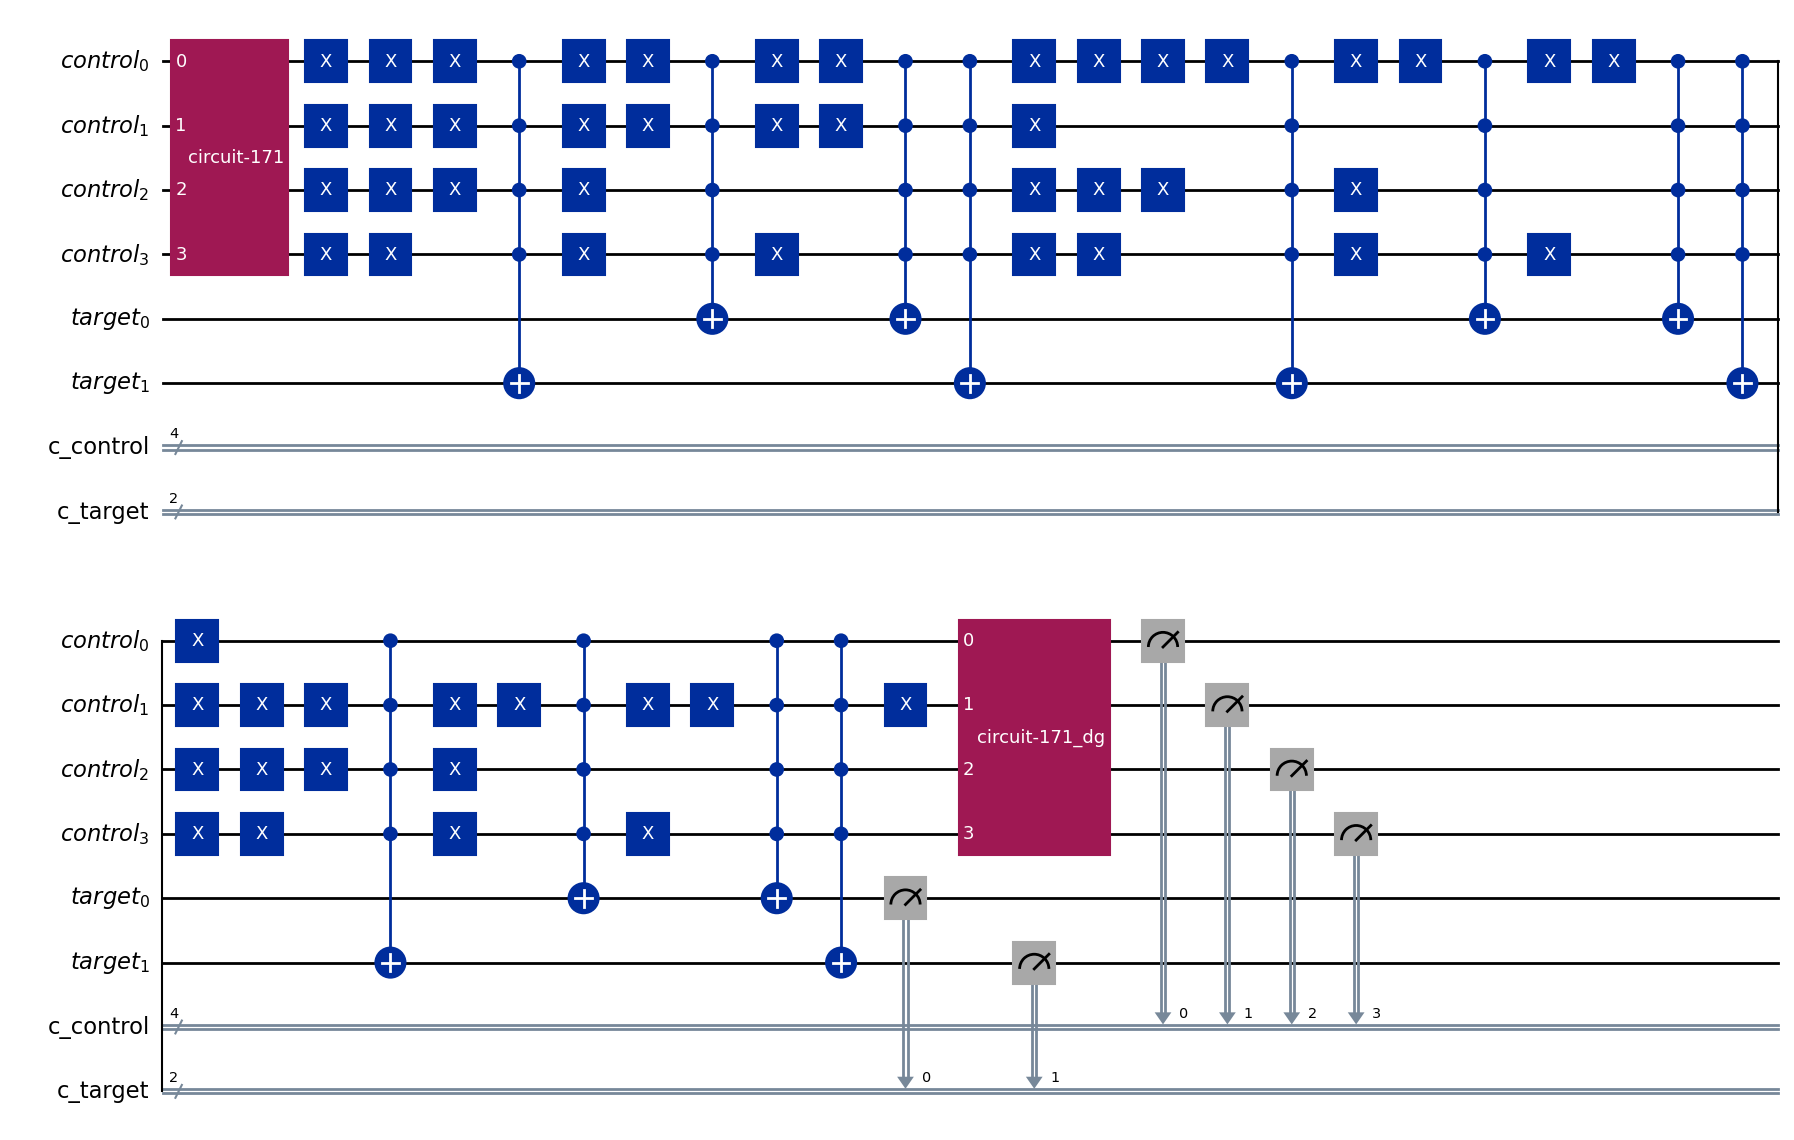

In [10]:
qc.draw('mpl')

# Celda 11: Ejecución en hardware Real (Requiere modificaciones en la transpilación)

In [11]:
# Celda final para ejecutar el circuito HSPAbelian en hardware cuántico real
# Utilizando Qiskit Runtime Service

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit import transpile
import math

# Definición del circuito a ejecutar (según lo especificado)
# Número total de elementos
total_elements =

# Secuencia base
base_sequence =

# Definición de datos periódicos y parámetros iniciales
data2 = (base_sequence * (total_elements // len(base_sequence))) + base_sequence[:total_elements % len(base_sequence)]
moduli =
n_target = math.ceil(math.log2(max(data2) + 1))
f_mapping = dict(enumerate(data2))
print("Mapeo de la función:")
print(f_mapping)

# Construcción del circuito HSP
print("Construyendo circuito HSP...")
qc = hsp_solver(f_mapping, moduli, n_target)
print(f"Circuito construido con {qc.num_qubits} qubits y {qc.depth()} de profundidad")

# Paso 1: Conectar con IBM Quantum usando tu token personal
token = ""

# Guardar y cargar el servicio si es necesario
if token:
    QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)

service = QiskitRuntimeService()

# Paso 2: Seleccionar un backend real (el menos ocupado con suficientes qubits)
backend = service.least_busy(simulator=False, operational=True, min_num_qubits=qc.num_qubits)

print(f"Ejecutando en el backend: {backend.name}")

# Paso 3: Transpilar el circuito para adaptarlo al backend específico
transpiled_circuit = transpile(qc, backend=backend, optimization_level=3)

# Validar que el circuito cumple con las restricciones del backend (opcional)
print(f"Operaciones soportadas por {backend.name}: {backend.target.operation_names}")
print(f"Circuito transpilado:\n{transpiled_circuit}")

# Paso 4: Crear un Sampler y configurar las opciones usando update()
sampler = Sampler(mode=backend)

# Configurar opciones válidas para el Sampler (por ejemplo, número de shots)
sampler.options.update(default_shots=2048)

# Ejecutar el circuito usando Sampler dentro del modo especificado (backend)
job = sampler.run([transpiled_circuit])
print("Trabajo enviado. Esperando resultados...")

# Esperar a que termine la ejecución y obtener los resultados
result = job.result()

# Acceder dinámicamente al atributo basado en el nombre del registro clásico
register_name = list(result[0].data.keys())[0]  # Obtener dinámicamente el nombre del registro clásico
counts = result[0].data[register_name].get_counts()
hidden_subgroup = extract_hidden_subgroup_improved(counts, moduli)

# Conversión del subgrupo oculto a enteros
hidden_subgroup_int = process_hidden_subgroup(hidden_subgroup, moduli)

print("\nResultados finales:")
print("Subgrupo detectado (enteros):", hidden_subgroup_int)
print("Subgrupo detectado:", hidden_subgroup)



SyntaxError: invalid syntax (<ipython-input-11-8f4e15056a03>, line 10)